In [1]:
# eval models

In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from PyPDF2 import PdfMerger
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join

2023-06-02 13:23:12.417303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 13:23:12.930029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
wireplane = 'U'

In [4]:
x_test = np.load('/home/vlian/processed_data_CURRENT/x_test_'+wireplane+'.npy')
y_test = np.load('/home/vlian/processed_data_CURRENT/y_test_AE_'+wireplane+'.npy')

In [5]:
model0 = load_model('../models/model_AE_2048_no_pooling'+wireplane+'plane_nu.h5')
model1 = load_model('./models/model_AE_12800_low_ADC_5_10Uplane_nu.h5')
model2 = load_model('./models/model_AE_12800_low_ADC_5_13_2Uplane_nu.h5')

2023-06-02 13:23:14.136474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 13:23:14.195106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 13:23:14.195183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 13:23:14.199123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 13:23:14.199181: I tensorflow/compile

In [6]:
mean_ = np.load('/home/vlian/processed_data_CURRENT/x_train_U.npy')
mean0 = np.mean(mean_)
std0 = np.std(mean_)

In [7]:
mean1 = np.load('/home/vlian/Workspace/samples_for_train_low_adc/low_adc_U_mean_adc_5_10.npy')
std1 = np.load('/home/vlian/Workspace/samples_for_train_low_adc/low_adc_U_std_adc_5_10.npy')

In [8]:
mean2 = np.load('/home/vlian/Workspace/samples_for_train_low_adc/low_adc_U_mean_adc_5_13.npy')
std2 = np.load('/home/vlian/Workspace/samples_for_train_low_adc/low_adc_U_std_adc_5_13.npy')

### Original model
> Trained with 100k nu_cc/nu_es events

In [9]:
def get_adc_group(x_test_, y_test_, pred):
    adc_3_5_x = []
    adc_3_5_y = []
    adc_3_5_p = []

    adc_5_10_x = []
    adc_5_10_y = []
    adc_5_10_p = []

    adc_10_15_x = []
    adc_10_15_y = []
    adc_10_15_p = []

    adc_15_20_x = []
    adc_15_20_y = []
    adc_15_20_p = []

    noise_x = []
    noise_y = []
    noise_p = []

    adc_gt_20_x = []
    adc_gt_20_y = []
    adc_gt_20_p = []

    for i, wave in enumerate(y_test_):
        if sum(abs(wave)) == 0:
            noise_y.append(wave)
            noise_p.append(pred[i])
            noise_x.append(x_test_[i])
            continue
        max_adc = max(abs(wave))
        if max_adc > 3 and max_adc <= 5:
            adc_3_5_y.append(wave)
            adc_3_5_p.append(pred[i])
            adc_3_5_x.append(x_test_[i])
        elif max_adc > 5 and max_adc <=10:
            adc_5_10_y.append(wave)
            adc_5_10_p.append(pred[i])
            adc_5_10_x.append(x_test_[i])
        elif max_adc > 10 and max_adc <= 15:
            adc_10_15_y.append(wave)
            adc_10_15_p.append(pred[i])
            adc_10_15_x.append(x_test_[i])
        elif max_adc > 15 and max_adc <= 20:
            adc_15_20_y.append(wave)
            adc_15_20_p.append(pred[i])
            adc_15_20_x.append(x_test_[i])
        else:
            adc_gt_20_y.append(wave)
            adc_gt_20_p.append(pred[i])
            adc_gt_20_x.append(x_test_[i])

    grouped_waves = [
        [adc_3_5_x, adc_3_5_y, adc_3_5_p], 
        [adc_5_10_x, adc_5_10_y, adc_5_10_p], 
        [adc_10_15_x, adc_10_15_y, adc_10_15_p],
        [adc_15_20_x, adc_15_20_y, adc_15_20_p],
        [adc_gt_20_x, adc_gt_20_y, adc_gt_20_p],
        [noise_x, noise_y, noise_p]
    ]

    return grouped_waves


In [10]:
group_num_labels = {
                    0: 'adc_3_5',
                    1: 'adc_5_10',
                    2: 'adc_10_15',
                    3: 'adc_15_20',
                    4: 'adc_gt_20',
                    5: 'noise'
                    }

In [11]:
def eval_group(group_num, grouped_waves):
    if group_num > 4:
        print('arg should be less than 6')
        return -1
    x = grouped_waves[group_num][0]
    y = grouped_waves[group_num][1]
    infer = grouped_waves[group_num][2]

    positive_x = []
    positive_y = []
    positive_p = []

    negative_x = []
    negative_y = []
    negative_p = []

    for i, wave in enumerate(infer):
        if max(abs(wave)) > 3:
            positive_x.append(x[i])
            positive_y.append(y[i])
            positive_p.append(wave)
        else:
            negative_x.append(x[i])
            negative_y.append(y[i])
            negative_p.append(wave)
    print(group_num_labels[group_num])
    print('{:<12}{}'.format('Total:', len(x)))
    print('{:<12}{}'.format('True Pos: ', len(positive_x)))
    print('{:<12}{}'.format('False Pos: ', len(negative_x)))
    print()

    return [[positive_x, positive_y, positive_p], [negative_x, negative_y, negative_p]]

In [12]:
x_test_scaled0 = x_test.copy()
x_test_scaled0 = (x_test_scaled0-mean0)/std0
y_test_scaled0 = y_test.copy()
y_test_scaled0 = (y_test_scaled0-mean0)/std0

predictions0 = model0.predict(x_test_scaled0, batch_size=4096)
predictions0 = predictions0.reshape(predictions0.shape[0], predictions0.shape[1])

pred0 = predictions0*std0 + mean0

grouped_waves0 = get_adc_group(x_test, y_test, pred0)


2023-06-02 13:23:18.095270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-02 13:23:18.851792: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


25/25 [==============================] - 3s 14ms/step


In [13]:
x_test_scaled1 = x_test.copy()
x_test_scaled1 = (x_test_scaled1-mean1)/std1
y_test_scaled1 = y_test.copy()
y_test_scaled1 = (y_test_scaled1-mean1)/std1

predictions1 = model1.predict(x_test_scaled1, batch_size=4096)
predictions1 = predictions1.reshape(predictions1.shape[0], predictions1.shape[1])

pred1 = predictions1*std1 + mean1

grouped_waves1 = get_adc_group(x_test, y_test, pred1)

25/25 [==============================] - 0s 14ms/step


In [14]:
x_test_scaled2 = x_test.copy()
x_test_scaled2 = (x_test_scaled2-mean2)/std2
y_test_scaled2 = y_test.copy()
y_test_scaled2 = (y_test_scaled2-mean2)/std2

predictions2 = model2.predict(x_test_scaled2, batch_size=4096)
predictions2 = predictions2.reshape(predictions2.shape[0], predictions2.shape[1])

pred2 = predictions2*std2 + mean2

grouped_waves2 = get_adc_group(x_test, y_test, pred2)

25/25 [==============================] - 1s 15ms/step


In [15]:
# [[positive_x, positive_y, positive_p], [negative_x, negative_y, negative_p]]

In [16]:
tpr0 = []
total0 = []
for i in range(5):
    eval0 = eval_group(i, grouped_waves0)

    tpr0.append(len(eval0[0][0]))

    total0.append(len(eval_group(i, grouped_waves0)[0][0]))

adc_3_5
Total:      3951
True Pos:   439
False Pos:  3512

adc_5_10
Total:      6610
True Pos:   2815
False Pos:  3795

adc_10_15
Total:      4486
True Pos:   4071
False Pos:  415

adc_15_20
Total:      3304
True Pos:   3294
False Pos:  10

adc_gt_20
Total:      31649
True Pos:   31649
False Pos:  0

arg should be less than 6


TypeError: 'int' object is not subscriptable

In [17]:
tpr1 = []
for i in range(6):
    tpr1.append(len(eval_group(i, grouped_waves1)[0][0]))

adc_3_5
Total:      3951
True Pos:   826
False Pos:  3125

adc_5_10
Total:      6610
True Pos:   3686
False Pos:  2924

adc_10_15
Total:      4486
True Pos:   4212
False Pos:  274

adc_15_20
Total:      3304
True Pos:   3289
False Pos:  15

adc_gt_20
Total:      31649
True Pos:   31646
False Pos:  3

arg should be less than 6


TypeError: 'int' object is not subscriptable

In [18]:
tpr2 = []
for i in range(6):
    tpr2.append(len(eval_group(i, grouped_waves2)[0][0]))

adc_3_5
Total:      3951
True Pos:   855
False Pos:  3096

adc_5_10
Total:      6610
True Pos:   3696
False Pos:  2914

adc_10_15
Total:      4486
True Pos:   4216
False Pos:  270

adc_15_20
Total:      3304
True Pos:   3292
False Pos:  12

adc_gt_20
Total:      31649
True Pos:   31648
False Pos:  1

arg should be less than 6


TypeError: 'int' object is not subscriptable

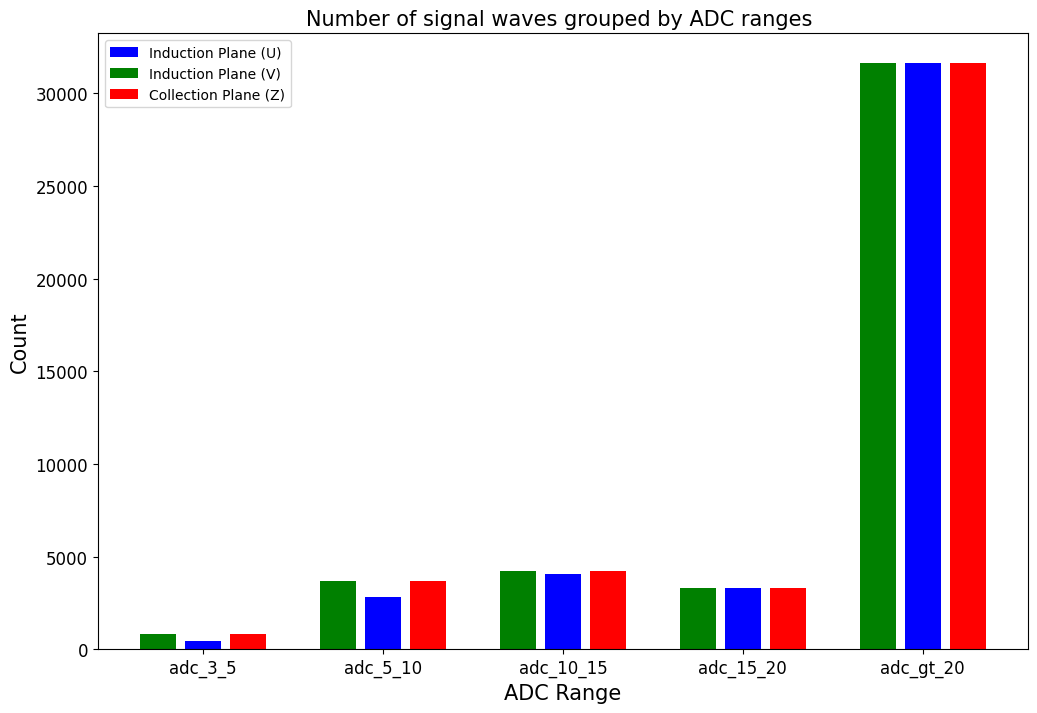

In [21]:
fig = plt.figure(figsize=(12,8))
plt.title('Number of signal waves grouped by ADC ranges ', size=15)

x_labels = [group_num_labels[i] for i in range(5)]
bar_width = 0.2

plt.bar([i for i in range(5)], tpr0, width=bar_width, color='blue', label='Induction Plane (U)')
plt.bar([i-bar_width - bar_width/4 for i in range(5)], tpr1, width=bar_width, color='green', label='Induction Plane (V)')
plt.bar([i+bar_width + bar_width/4 for i in range(5)], tpr2, width=bar_width, color='red', label='Collection Plane (Z)')



plt.xticks([i for i in range(5)], x_labels, size=12)
plt.yticks(size=12)
plt.legend()
plt.xlabel('ADC Range', size=15)
plt.ylabel('Count', size=15)
#filename = './histograms/file_group' + str(grp) +'.png'
#plt.savefig(filename, facecolor='w', bbox_inches='tight')
#plt.close()
plt.show()